# 폐렴 검출

In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras

import albumentations as A
import tensorflow as tf
import pydicom as dcm
import pandas as pd
import numpy as np
import math

import cv2
import os

WIDTH, HEIGHT = 512, 512
RATIO_RESIZING = 1024/WIDTH
NUM_CLASSES = 1
BATCH_SIZE = 1
NUM_DATASET = 6012
RATIO_TRAIN_VALID = 0.8
NUM_TRAIN = int(NUM_DATASET * RATIO_TRAIN_VALID)
NUM_VALID = NUM_DATASET - NUM_TRAIN

BASE_DIR = "/home/yang/바탕화면/RSNA"
#BASE_DIR = "C:/Users/yhu04/rsna-pneumonia-detection-challenge"

# 1. Anchor Box

In [2]:
def corners_to_xywh(boxes):
    return tf.concat([(boxes[..., :2] + boxes[..., 2:])/2.0, boxes[..., 2:] - boxes[..., :2]], axis = -1)

def xywh_to_corners(boxes):
    return tf.concat([boxes[..., :2] - boxes[..., 2:]/2.0, boxes[..., :2] + boxes[..., 2:]/2.0], axis = -1)

In [3]:
def compute_iou(boxes1, boxes2):
    # 1. Intersection
    # 1.1 ~ 1.3
    boxes1_corners = xywh_to_corners(boxes1)
    boxes2_corners = xywh_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    
    # 1.4 ~ 1.5 과정
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    
    # 2. Union
    # 2.1
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    
    # 2.2.
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    
    # 3. IOU
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [4]:
def Find_Anchor_Area(base_dir = BASE_DIR, ratio = RATIO_RESIZING):
    def GT_Box_len(base_dir = base_dir, ratio = ratio):
        # 1. csv 파일 로드
        data_info = pd.read_csv(base_dir+"/stage_2_train_labels.csv")
        data_info = data_info.drop(data_info[data_info["Target"] == 0].index)
        data_info.reset_index(drop=True, inplace = True)
        #data_info

        # 2. image, box and class 로드
        for i, file_name in enumerate(data_info["patientId"]):
            box = np.array(data_info.iloc[i, 3:5], dtype = "int32")
            yield int(math.sqrt(box[0]/ratio * box[1]/ratio))
        
    gen = GT_Box_len()
    lengths = list(gen)
    lengths.sort()
    min_len = lengths[0]
    return [min_len*(2**i) for i in range(5)]

In [5]:
class AnchorBox:
    """
    P3 ~ P7의 feature maps size만큼 Anchor Box 생성
    strides = [8, 16, 32, 64, 128]
    AnchorBox format : [x, y , width, height]
    """
    def __init__(self):
        areas = Find_Anchor_Area() #[24, 48, 96, 192, 384]
        self._areas = [x ** 2 for x in areas]
        self.aspect_ratios = [0.5, 1.0, 2.0] # 종횡비 1:2, 1:1, 2:1
        self.scales = [2 ** x for x in [0, 1/3, 2/3]]
        
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2** i for i in range(3, 8)]
        self._anchor_dims = self._compute_dims()
        
    def __del__(self):
        print("AnchorBox is destructed")
        
    def _compute_dims(self):
        """
        1. 각 앵커 너비에 대해서(5개) 각 종횡비에 따른 3개의 anchor box의 height와 width를 구한다.
        2. 위에서 구한 3개의 앵커박스에 대해 scaler 3개를 곱하여 총 9개의 anchor box를 생성한다.(== num_anchors)
        
        return
            shape : 앵커박스 너비 별 * (1, 1, 9, 2) // 앵커박스 너비 수 * (1, 1, num_anchors, len(width, height))
            즉 한 좌표에 대한 45개 앵커박스 생성
        """
        anchor_dims_all = []
        for area in self._areas: # 5
            anchor_dims = []
            for ratio in self.aspect_ratios: # 3
                # height와 width를 구하기
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                #print(anchor_height, anchor_width)
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                # 각 anchor box에 대한 3개의 scale 적용 -> X3
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all
    
    def _get_anchors(self, feature_height, feature_width, level):
        # 1. 각 중심 좌표 찾기
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5                        # (feature_width,  1) 
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5                       # (feature_height,  1) 
        # 축소된 feature map에서의 
        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level-3] # (2, feature_width, feature_height) -> (feature_width, feature_height, 2)
        centers = tf.expand_dims(centers, axis= 2)                                  # (feature_width, feature_height, 1, 2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])                    # (feature_width, feature_height, 9, 2)
        
        # 2. 각 중심 좌표에 해당 feature map size에 해당하는  Anchor box 각 대입
        dims = tf.tile(self._anchor_dims[level-3], [feature_height, feature_width, 1, 1]) # (feature_width, feature_height, 9, 2)
        anchors = tf.concat( [centers, dims], axis = -1 )  # (feature_width, feature_height, 9, 4)
        
        return tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4])
    
    def get_anchors(self, image_height= HEIGHT, image_width=WIDTH):
        """
        모든 피라미드 feature 계층맵에서 Anchor box 생성하기
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / (2 **i)),
                tf.math.ceil(image_width / (2 **i)),
                i
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis = 0)

a = AnchorBox()
ab = a.get_anchors()
print(ab)

# 2. Construect Model
## - Transfer Learning from ImageNet
## - Fine-turning
###   Learning Freeze Backbone -> Learning Freeze Backbone on Low Learning Rate)

In [6]:
def get_backbone(trainable_flag, width = WIDTH, height = HEIGHT):
    backbone = keras.applications.ResNet50(include_top=False, input_shape=(width, height, 3), weights = 'imagenet')
    """
    우선 backbone weight는 Freeze한다.
    """
    backbone.trainable = trainable_flag
    
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [7]:
class FeaturePyramid(keras.layers.Layer):
    def __init__(self, trainable_flag, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone(trainable_flag)
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [8]:
def build_head(output_filters, bias_init):
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    # Weight 초기화 (0, 0.01)
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init))
        head.add(keras.layers.ReLU())
    head.add(keras.layers.Conv2D(output_filters, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init))
    return head

In [9]:
class RetinaNet(keras.Model):
    def __init__(self, trainable_flag, num_classes=NUM_CLASSES, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(trainable_flag, backbone = backbone)
        self.num_classes = num_classes
        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")
        
    def call(self, image, batch_size = BATCH_SIZE, training=False):
        features = self.fpn(image, training=training)
        
        box_outputs = []
        cls_outputs = []
        
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [batch_size, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [batch_size, -1, self.num_classes])
            )
        box_outputs = tf.concat(box_outputs, axis=1)
        cls_outputs = tf.concat(cls_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1) # (1, Number of Anchor Boxes, 5)

# Feature Test
"""
데이터가 RetinaNet에서 Anchor box 클래스 레이블과 좌표레이블과의 계산을 손쉽게 하기 위해
reshape하는 것을 보여주기 위한 Test Code
"""

### P6 class # (4, 4, 9)
num_class = 1
cls6 = [i for i in range(1, 145)]
cls6 = tf.cast(cls6, dtype = "float32")
cls6 = tf.reshape(cls6, [4, 4, 9])
print(f"cls6\n{cls6}")

### P6 box # (4, 4, 36)
box6 = []
for i in range(1, 145):
    for j in range(1,5):
        box6.append(i + 0.1*j)
box6 = tf.cast(box6, dtype = "float32")
box6 = tf.reshape(box6, [4, 4, 36])
print(f"\nbox6\n{box6}")


### P7 class # (2, 2, 9)
cls7 = [i+144 for i in range(1, 37)]
cls7 = tf.cast(cls7, dtype = "float32")
cls7 = tf.reshape(cls7, [2, 2, 9])
print(f"\ncls7\n{cls7}")

### P7 box # (2, 2, 36)
box7 = []
for i in range(1, 37):
    for j in range(1,5):
        box7.append(i+144 + 0.1*j)
box7 = tf.cast(box7, dtype = "float32")
box7 = tf.reshape(box7, [2, 2, 36])
print(f"\nbox7\n{box7}")

cls_feature = [cls6, cls7]
box_feature = [box6, box7]

cls_outputs = []
box_outputs = []
num_class = 1

for p in range(2):
    h = tf.shape(cls_feature[p])[1]
    w = tf.shape(cls_feature[p])[2]
    box_outputs.append(tf.reshape(box_feature[p], [1, -1, 4]))
    cls_outputs.append(tf.reshape(cls_feature[p], [1, -1, num_class]))

box_outputs = tf.concat(box_outputs, axis=1)
cls_outputs = tf.concat(cls_outputs, axis=1)
output = tf.concat([box_outputs, cls_outputs], axis=-1)
print(f"\noutput\n")
output

# 3. Loss Function

In [10]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta
        
    def call(self, y_true, y_pred):
        # 여기서는 batch_size가 1이므로
        # y_true = [65, 66, 70, 50]
        # y_pred = [65, 80, 50, 64]

        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        # 여기서는 batch_size가 1이므로
        # y_true = [0, 1]
        # y_pred = [0.3, 0.7]
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        
        probs = tf.nn.sigmoid(y_pred)
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetLoss(tf.losses.Loss):
    def __init__(self, num_classes=NUM_CLASSES, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_true -> (1, Number of Anchor Boxes, 5)        
        # 1. True Label
        box_labels = y_true[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        ) # -> (1, Number of Anchor Boxes, Number of Classes)
        
        # y_pred -> (1, Number of Anchor Boxes, 4 + Number of Classes)
        # 2. Pred
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_predictions = y_pred[:, :, :4]
        cls_predictions = y_pred[:, :, 4:]
        
        # 3. Loss 계산
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        
        # ignorance mask가 존재하면 loss를 0으로 만들어 cls 계산에 제외하고 
        # positive이거나 negative이면 loss 계산 -> Foregound or Background 계산
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        
        # positive mask일때만 loss 계산하고, negative거나 ignorance면 loss를 0으로 만들어 계산에 제외.
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        """
        num_positive = tf.reduce_sum(positive_mask, axis=-1)
        normalizer = tf.where(tf.equal(num_positive, 0.0), 1.0, num_positive)
        """
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        
        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

## call 연습 코드
class A:
    def __init__(self, value = None):
        self.value = value
    
    def call(self, a, b):
        print(a,b)
        diff = a - b
        return diff

a = A()
a.call(1,2)

In [2]:
## Loss function Test
### Classification Test
a = tf.cast([[0.3, 0.4], [0.7, 0.4]], dtype = "float32")
y_true = tf.cast([0, 1.0], dtype = "float32")
print(f"y_true : {y_true}")


label = tf.one_hot(
            tf.cast(y_true, dtype=tf.int32),
            depth=2,
            dtype=tf.float32,
        )
print(f"label\n{label}\n")

alpha = tf.where(tf.equal(label, 1.0), 0.25, (1.0 - 0.25))
print(f"alpha\n{alpha}\n")

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=label, logits=a)
print(f"cross_entropy\n{cross_entropy}\n")

probs = tf.nn.sigmoid(a)
print(f"probs(sigmoid(y_pred))\n{probs}\n")

pt = tf.where(tf.equal(label, 1.0), probs, 1 - probs)
print(f"pt\n{pt}\n")

loss = alpha * tf.pow(1.0 - pt, 2) * cross_entropy
loss = tf.reduce_sum(loss, axis=-1)
print(f"Focal loss\n{loss}\n")

positive_mask = tf.cast(tf.greater(y_true, -1.0), dtype=tf.float32)
negative_mask = tf.cast(tf.equal(y_true, -1.0), dtype=tf.float32)
ignore_mask = tf.cast(tf.equal(y_true, -2.0), dtype=tf.float32)

loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, loss) # ignore_mask 무시
print(f"P+N_loss\n{loss}\n")

#normalizer = tf.reduce_sum(positive_mask, axis=-1)
num_positive_anchor = tf.reduce_sum(positive_mask, axis=-1)
normalizer = tf.where(tf.equal(num_positive_anchor, 0), 1, num_positive_anchor)
print(f"Normalizer\n{normalizer}\n")

loss = tf.math.divide_no_nan(tf.reduce_sum(loss, axis=-1), normalizer)
print(f"final_loss\n{loss}")

#########################################################################
### Box test
print("\n\n#########################################################################\nBox\n")
pred, true = [[65, 66, 70, 50], [120, 125, 30, 50]], [[65, 80, 50, 64], [90, 150, 20, 40]]
pred, true = tf.cast(pred, dtype = "float32"), tf.cast(true, dtype = "float32")
difference = true - pred
print(f"difference\n{difference}")

absolute_difference = tf.abs(difference)
squared_difference = difference ** 2

loss = tf.where(
            tf.less(absolute_difference, 15.0),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
print(f"\nloss\n{loss}")
loss = tf.reduce_sum(loss, axis=-1)
print(f"\nSmooth L1 loss\n{loss}")

loss = tf.where(tf.equal(positive_mask, 1.0), loss, 0.0)
print(f"\nP_loss\n{loss}")

loss = tf.math.divide_no_nan(tf.reduce_sum(loss, axis=-1), normalizer)
print(f"\nfinal_loss\n{loss}")

y_true : [0. 1.]
label
[[1. 0.]
 [0. 1.]]

alpha
[[0.25 0.75]
 [0.75 0.25]]

cross_entropy
[[0.5543552  0.91301525]
 [1.103186   0.5130153 ]]

probs(sigmoid(y_pred))
[[0.5744425  0.59868765]
 [0.66818774 0.59868765]]

pt
[[0.5744425  0.40131235]
 [0.33181226 0.59868765]]

Focal loss
[0.27053523 0.39006412]

P+N_loss
[0.27053523 0.39006412]

Normalizer
2.0

fanal_loss
0.3302996754646301


#########################################################################
Box

difference
[[  0.  14. -20.  14.]
 [-30.  25. -10. -10.]]

loss
[[ 0.  98.  19.5 98. ]
 [29.5 24.5 50.  50. ]]

Smooth L1 loss
[215.5 154. ]

P_loss
[215.5 154. ]

fanal_loss
184.75


# 4. Generator Dataset

In [11]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes) # -> (Number of Anchor Boxes, Number of GT boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        
        # Index of Anchor box having max IoU
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target
    
    def encode(self, gt_boxes, cls_ids, width = WIDTH, height = HEIGHT):
        # 0. gt_boxes -> (Number of GT_boxes, 4)
        gt_boxes = tf.cast(gt_boxes, dtype = tf.float32)
        
        # 1. Each Anchor box label and encode
        anchor_boxes = self._anchor_box.get_anchors(width, height)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(anchor_boxes, gt_boxes)
        
        # GT boxes with Anchor box having max IoU
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        
        # Computing offset value of anchor box with following SSD paper
        # So, What does "offset" mean? --> Just Displacement difference
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        ###########################################
        # 2. Class label
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        
        # To find object class label not relation with ignorance and negative anchors
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids)
        
        # To find ignorance anchors
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        
        # Reshape
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        label = tf.reshape(label, [1, tf.shape(label)[0], tf.shape(label)[1]])
        return label

In [12]:
def make_dictionary(base_dir = BASE_DIR, ratio = RATIO_RESIZING, width = WIDTH, height = HEIGHT):
    # 1. csv 파일 로드
    data_info = pd.read_csv(base_dir+"/stage_2_train_labels.csv")
    data_info = data_info.drop(data_info[data_info["Target"] == 0].index)
    data_info.reset_index(drop=True, inplace = True)
    #data_info
    
    id_boxes = {}
    # 2. 반복문을 돌려서 id : [[box1], [box2],...] 형태로 만들기
    for i, patientId in enumerate(data_info["patientId"]):
        box = np.array(data_info.iloc[i, 1:5], dtype = "float32")/ratio
        box = box.tolist()
        
        if patientId in id_boxes:
            id_boxes[patientId].append(box)
        else:
            id_boxes[patientId] = [box]
    
    return id_boxes

In [13]:
class Preprocessor:
    def __init__(self, num_train = NUM_TRAIN, base_dir = BASE_DIR):
        self.base_dir = base_dir
        self.num_train = num_train
        self.id_boxes = make_dictionary(self.base_dir)
        self.label_encoder = LabelEncoder()

    
    def __del__(self):
        print("Preprocessor is destructed")
    
    def train_preprocessor(self, width = WIDTH, height = HEIGHT):
        # augmentation function
        category_id_to_name = {0: 'pneumonia'}
        transformer_flip = A.Compose(
                [A.HorizontalFlip(p=1)],
                bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

        transformer_CLAHE = A.Compose(
                [A.CLAHE(p=1)],
                bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))
        
        for i, patientId in enumerate(self.id_boxes):
            if i == self.num_train:
                break
            # images laod and resizing
            image_dir = self.base_dir + f"/stage_2_train_images/{patientId}.dcm"
            image = dcm.read_file(image_dir).pixel_array
            image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_AREA)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            bboxes = self.id_boxes[patientId]
            cls = [0 for _ in range(len(bboxes))]
            #plt.imshow(image, cmap = plt.cm.bone)

            # 2.1. Filp
            flip_data = transformer_flip(image=image, bboxes=bboxes, category_ids=cls)
            flip_image = np.reshape(flip_data['image'], ((1, ) + flip_data['image'].shape))
            flip_bboxes = flip_data['bboxes'] # [[X_lefttop, Y_lefttop, W, H]]
            
            # [[X_lefttop, Y_lefttop, W, H]] -> [[X_center, Y_center, W, H]]
            flip_bboxes = np.asarray(flip_bboxes)
            flip_bboxes[:, :2] += flip_bboxes[:, 2:]/2

            flip_label = self.label_encoder.encode(flip_bboxes, cls)
            yield (flip_image/255., flip_label)

            # 2.2. CLAHE
            CLAHE_data = transformer_CLAHE(image=image, bboxes=bboxes, category_ids=cls)
            CLAHE_image = np.reshape(CLAHE_data['image'], ((1, ) + CLAHE_data['image'].shape))
            
            # [[X_lefttop, Y_lefttop, W, H]] -> [[X_center, Y_center, W, H]]
            bboxes = np.asarray(bboxes)
            bboxes[:, :2] += bboxes[:, 2:]/2

            CLAHE_label = self.label_encoder.encode(bboxes, cls)
            yield (CLAHE_image/255., CLAHE_label)
            
            # 2.3. Origin
            image = np.reshape(image, ((1,)+image.shape))
            yield (image/255., CLAHE_label)
            
    def valid_preprocessor(self, width = WIDTH, height = HEIGHT):
        label_encoder = LabelEncoder()
        for i, patientId in enumerate(self.id_boxes):
            if i >= self.num_train:
                # images laod and resizing
                image_dir = self.base_dir + f"/stage_2_train_images/{patientId}.dcm"
                image = dcm.read_file(image_dir).pixel_array
                image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_AREA)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
                bboxes = self.id_boxes[patientId]
                
                # [[X_lefttop, Y_lefttop, W, H]] -> [[X_center, Y_center, W, H]]
                bboxes = np.asarray(bboxes)
                bboxes[:, 0:2] += bboxes[:, 2:]/2
                
                cls = [0 for _ in range(len(bboxes))]
                
                label = self.label_encoder.encode(bboxes, cls)

                image = np.reshape(image, ((1,)+image.shape))
                yield (image/255., label)
           
    def test_preprocessor(self, width = WIDTH, height = HEIGHT):
        for i, patientId in enumerate(self.id_boxes):
            if i >= self.num_train:
                # images laod and resizing
                image_dir = self.base_dir + f"/stage_2_train_images/{patientId}.dcm"
                image = dcm.read_file(image_dir).pixel_array
                image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_AREA)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
                bboxes = self.id_boxes[patientId]

                image = np.reshape(image, ((1,)+image.shape))
                yield (image, bboxes)

In [14]:
preprocessor = Preprocessor()
anchorbox = AnchorBox()
anchors = anchorbox.get_anchors()
num_anchors = tf.shape(anchors)[0]

train_dataset = tf.data.Dataset.from_generator(
                    preprocessor.train_preprocessor,
                    (tf.float32, tf.float32),
                    (tf.TensorShape([1, HEIGHT, WIDTH, 3]), tf.TensorShape([1, num_anchors, 4 + NUM_CLASSES])),
                    )

valid_dataset = tf.data.Dataset.from_generator(
                    preprocessor.valid_preprocessor,
                    (tf.float32, tf.float32),
                    (tf.TensorShape([1, HEIGHT, WIDTH, 3]), tf.TensorShape([1, num_anchors, 4 + NUM_CLASSES])),
                    )

test_dataset = tf.data.Dataset.from_generator(
                    preprocessor.test_preprocessor,
                    (tf.int32, tf.int32),
                    (tf.TensorShape([1, HEIGHT, WIDTH, 3]), tf.TensorShape([None, 4])),
                    )

del preprocessor
del anchorbox

AnchorBox is destructed


### Check Training set test
for i, element in enumerate(train_dataset):
    img = element[0][0].numpy()
    plt.imshow(img, cmap=plt.cm.bone)
    if i == 3:
        break
    plt.show()

### Check Validation set
for i, element in enumerate(valid_dataset):
    print(element[1])
    img = element[0][0].numpy()
    plt.imshow(img, cmap=plt.cm.bone)
    if i == 3:
        break
    plt.show()

### Check Test set test
for i, element in enumerate(test_dataset):
    img = element[0][0].numpy()
    print(element[1])
    for j in range(element[1].shape[0]):
        x1, y1, w, h = element[1][j][0], element[1][j][1], element[1][j][2], element[1][j][3]
        img = cv2.rectangle(img, (x1, y1), (x1+w, y1 + h), (0,0,255), 3)
    plt.imshow(img, cmap=plt.cm.bone)
    if i == 3:
        break
    plt.show()

## LabelEncoder Test
anchor = [[65, 66, 70, 50], [120, 125, 30, 50], [80, 145, 30, 50], [63, 78, 50, 64], [85, 155, 25, 45], [50,30, 70, 40]]
true = [[65, 80, 50, 64], [90, 150, 20, 40]]
cls_ids = [0, 1]
anchor, true = tf.cast(anchor, dtype = "float32"), tf.cast(true, dtype = "float32")
cls_ids = tf.cast(cls_ids, dtype=tf.float32)
iou_matrix = compute_iou(anchor, true)
print(f"IoU\n{iou_matrix}\n")

match_iou, ignore_iou = 0.5, 0.4
#iou_matrix = [[0.644, 0.30], [0.14, 0.450], [0.54, 0.30], [0.20, 0.60],[0.2, 0.30], [0.24, 0.70]]
max_iou = tf.reduce_max(iou_matrix, axis = 1)
print(f"Max IoU\n{max_iou}\n")

#### max IoU index of Anchor box
matched_gt_idx = tf.argmax(iou_matrix, axis=1)
print(f"matched_gt_idx\n{matched_gt_idx}\n")

positive_mask = tf.greater_equal(max_iou, match_iou)
negative_mask = tf.less(max_iou, ignore_iou)
ignore_mask = tf.cast(tf.logical_not(tf.logical_or(positive_mask, negative_mask)), dtype = tf.float32)
#print(ignore_mask)
positive_mask = tf.cast(positive_mask, dtype=tf.float32)
negative_mask = tf.cast(negative_mask, dtype=tf.float32)

print(f"positive_mask\n{positive_mask}\n")
print(f"negative_mask\n{negative_mask}\n")
print(f"ignore_mask\n{ignore_mask}\n")

#### GT boxes with Anchor box having max IoU
matched_gt_boxes = tf.gather(true, matched_gt_idx)
print(f"matched_gt_boxes\n{matched_gt_boxes}\n")

matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
print(f"matched_gt_cls_ids\n{matched_gt_cls_ids}\n")

#### To find object class label not relation with ignorance and negative anchors
cls_target = tf.where(tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids)
print(f"cls_target\n{cls_target}\n")

#### To find ignorance anchors
cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
print(f"cls_target\n{cls_target}\n")

cls_target = tf.expand_dims(cls_target, axis=-1)
print(f"Final_cls_label\n{cls_target}\n")

def compute_box_target(anchor_boxes, matched_gt_boxes):
    box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    box_variance
    """Transforms the ground truth boxes into targets for training"""
    box_target = tf.concat(
        [
        (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
        tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
        ],
        axis=-1,
    )
    box_target = box_target / box_variance
    return box_target
box_target = compute_box_target(anchor, matched_gt_boxes)
print(f"Final_box_label\n{box_target}\n")

label = tf.concat([box_target, cls_target], axis=-1)

label = tf.reshape(label, [1,tf.shape(label)[0], tf.shape(label)[1]])
label
#print(f"Final_label\n{label}\n")

# 5. Training the Model
## 5.1. Freeze Backbone

In [ ]:
model_dir = "retinanet/"

# loss function
loss_fn = RetinaNetLoss()

# lr
epochs = 30
learning_rates = [2.5e-4, 5.0e-5, 2.5e-5, 5.0e-6, 1.0e-6]
learning_rate_boundaries = [ (NUM_TRAIN*3) * step for step in range(5, epochs, 5)]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

# model load -> Freeze the backbone
trainable = False
resnet50_backbone = get_backbone(trainable_flag = trainable)
model = RetinaNet(trainable_flag = trainable, backbone = resnet50_backbone)
model.compile(loss=loss_fn, optimizer=optimizer)

print(1)
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "Freezed_{epoch}"),
        monitor="val_loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

print(2)
model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data = valid_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)
print(3)

#### 중지 했을 때
model_dir = "retinanet/"

#### loss function
loss_fn = RetinaNetLoss()

epochs = 10
optimizer = tf.optimizers.SGD(learning_rate=2.5e-05, momentum=0.9)

##### model load -> Freeze the backbone
trainable = False
resnet50_backbone = get_backbone(trainable_flag = trainable)
model = RetinaNet(trainable_flag = trainable, backbone = resnet50_backbone)
model.compile(loss=loss_fn, optimizer=optimizer)

print(2)

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "Freezed_{epoch}"),
        monitor="val_loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 10
model.load_weights("retinanet/Fine-tuned_10")
model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data = valid_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

# 6. Inference Model
## 6.1. Heatmap without Non-Max Suppresion ( ver. 2)
### 성능 검증하는 코드도 있어야 한다. 이는 나중에 YOLO 4, 5할 때 진행하도록 한다.

In [15]:
class DecodePredictions(tf.keras.layers.Layer):
    def __init__(
        self,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = NUM_CLASSES
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = xywh_to_corners(boxes)
        return boxes_transformed

    def call(self, predictions, width = WIDTH, height = HEIGHT):
        anchor_boxes = self._anchor_box.get_anchors(width, height)
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        box_predictions = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)
        return {"boxes" : box_predictions, "scores" : cls_predictions}

    
def Visualize_Heattmap_on_Image(image, result, label=None, width = WIDTH, height = HEIGHT):
    boxes = result["boxes"][0]
    boxes = boxes.astype(int)
    scores = result["scores"][0]
    
    # 히트맵
    heatmap = np.zeros((height, width), dtype = "float32")
    
    # divider for heatmap
    divider = np.zeros((height, width), dtype = "float32")
    
    # 모든 스코어 합
    for box, score in zip(boxes, scores):
        xmin, ymin, xmax, ymax = box
        heatmap[ymin:ymax, xmin:xmax] += (score)
        divider[ymin:ymax, xmin:xmax] += 1
    
    # 평균
    heatmap /= divider
    heatmap = np.uint8(heatmap * 255)
    
    # 원래 label boxing하기
    # GT label
    if [label]:
        for i in range(len(label)):
            x1, y1, w, h = label[i][0], label[i][1], label[i][2], label[i][3]
            image = cv2.rectangle(image, (x1, y1), (x1+w, y1 + h), (255,0,0), 3)
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=plt.cm.bone)
    
    # overlap하기
    plt.imshow(heatmap, "jet", alpha = 0.5)
    plt.show()

/home/yang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


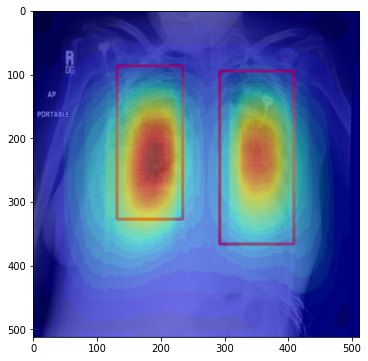

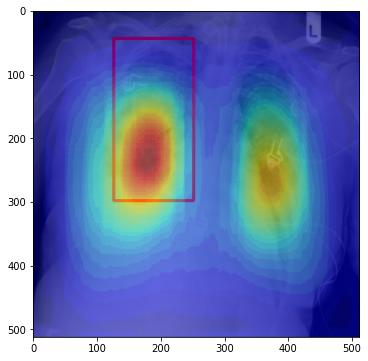

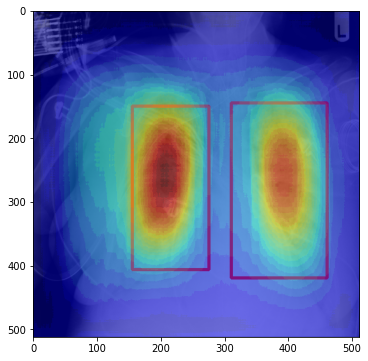

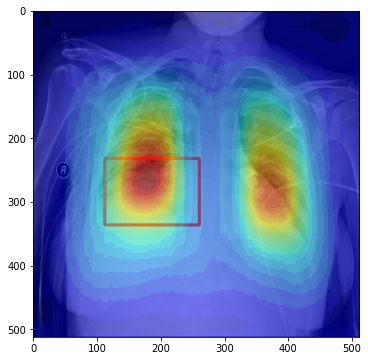

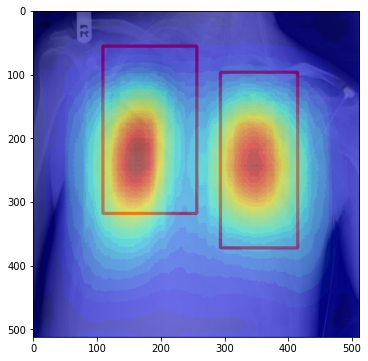

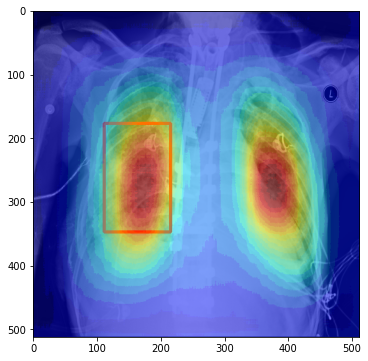

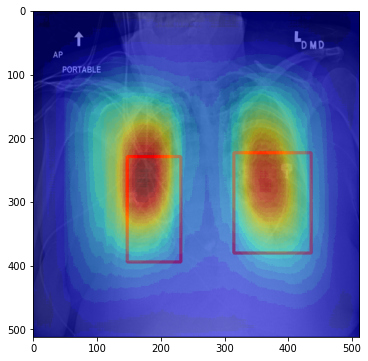

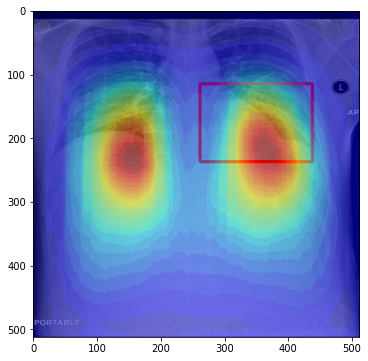

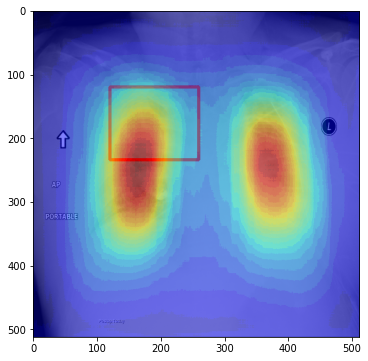

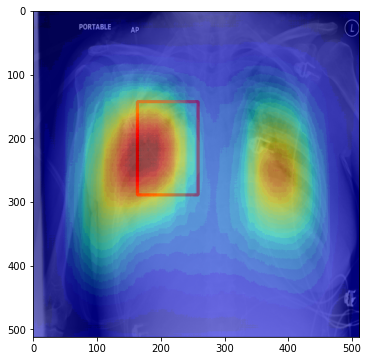

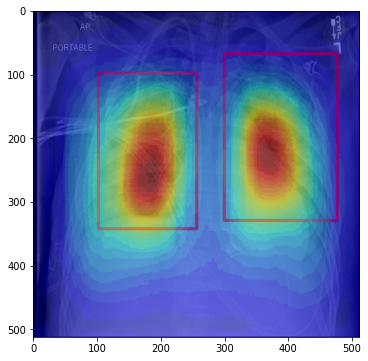

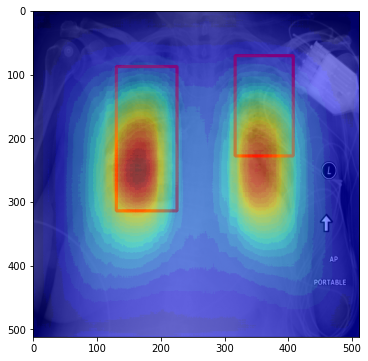

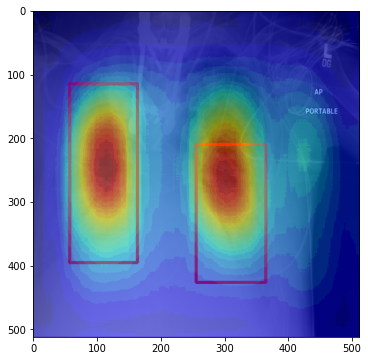

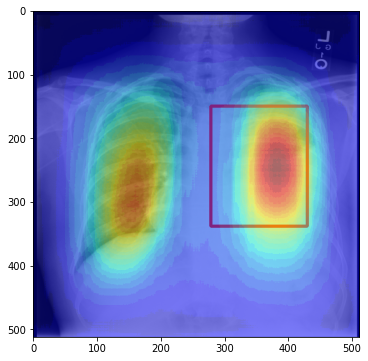

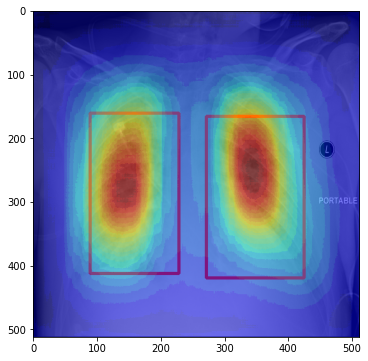

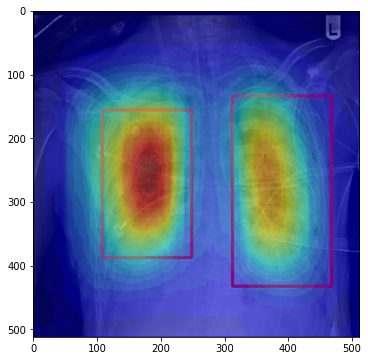

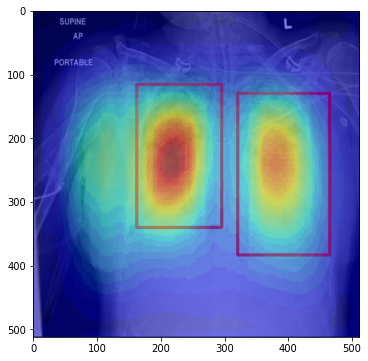

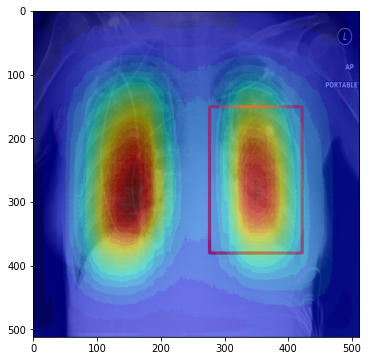

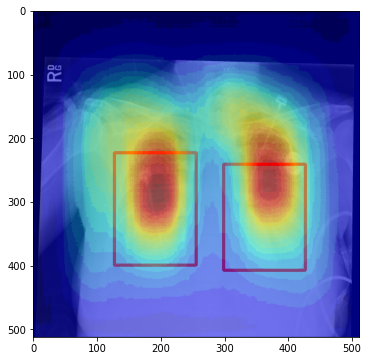

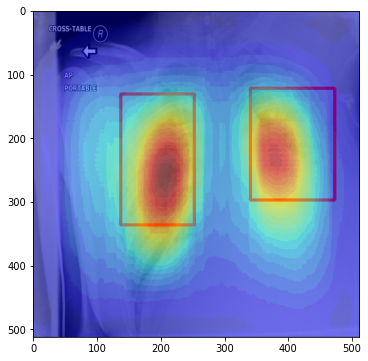

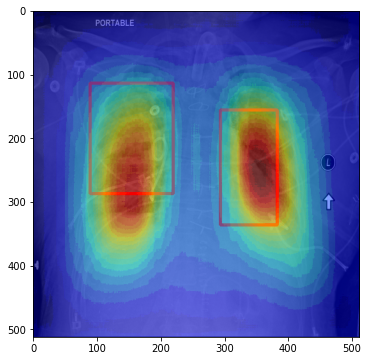

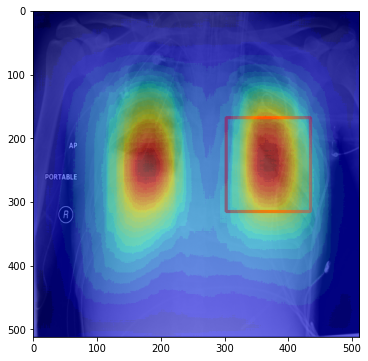

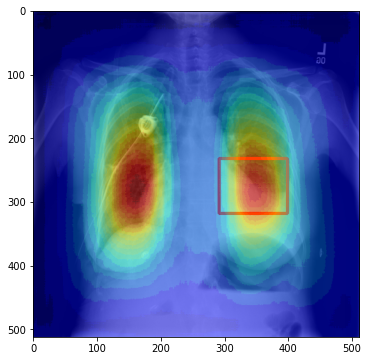

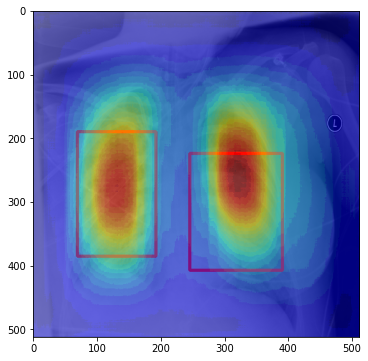

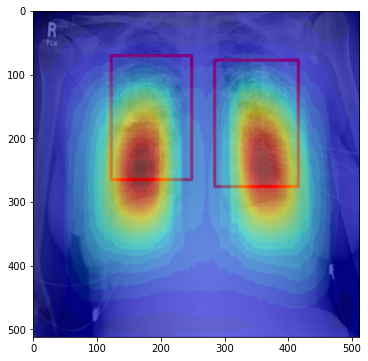

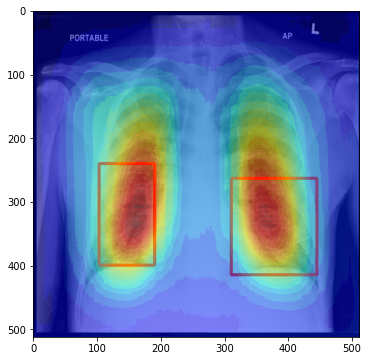

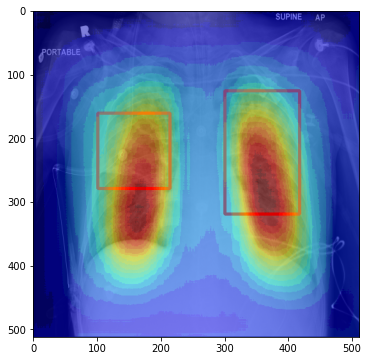

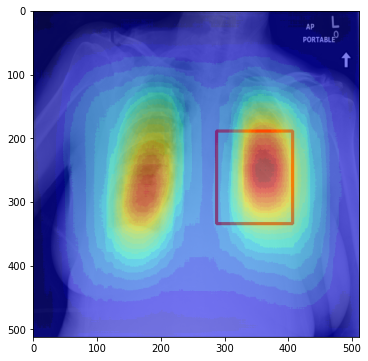

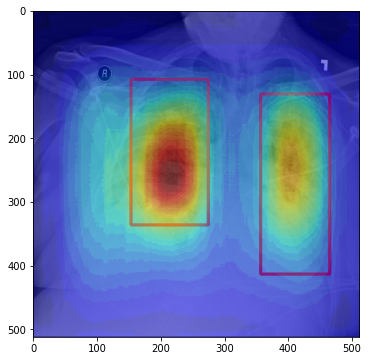

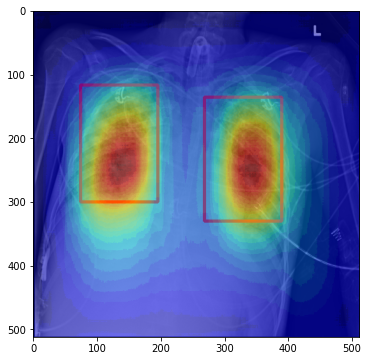

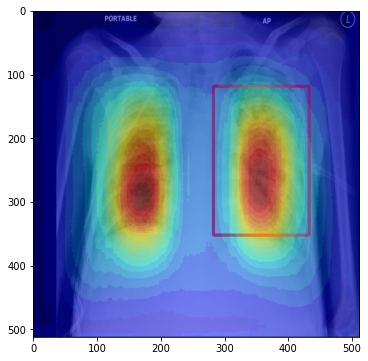

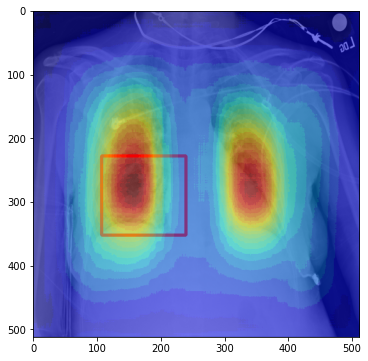

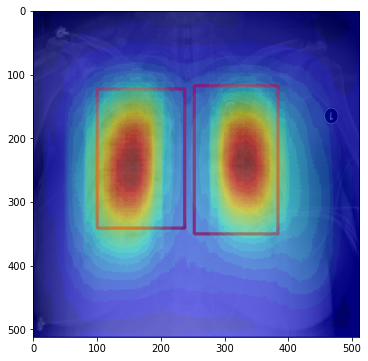

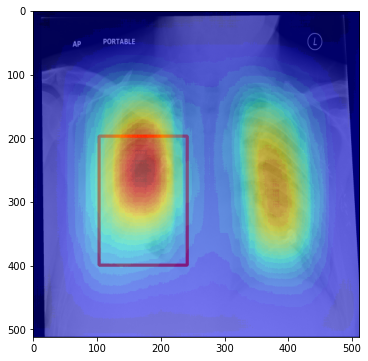

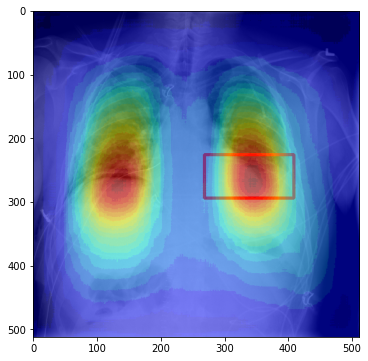

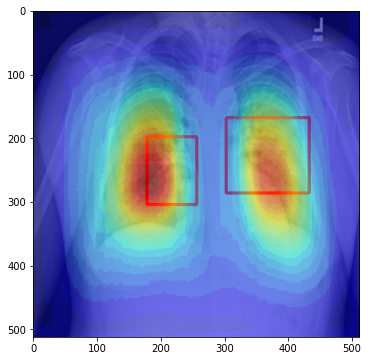

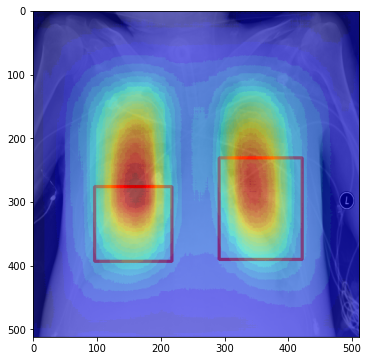

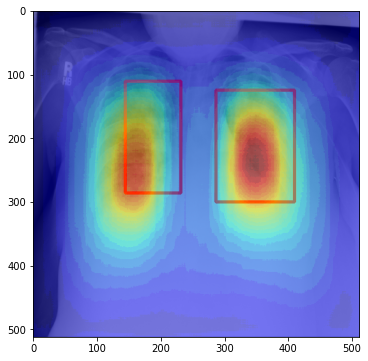

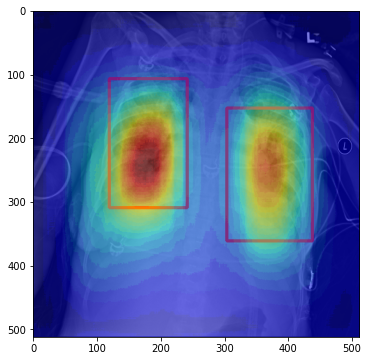

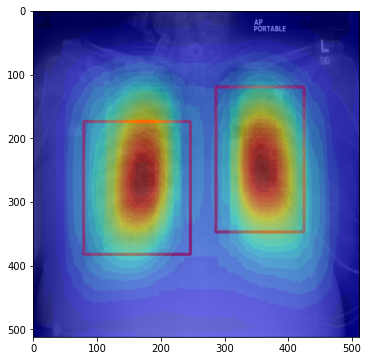

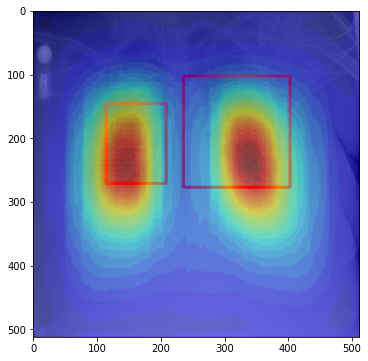

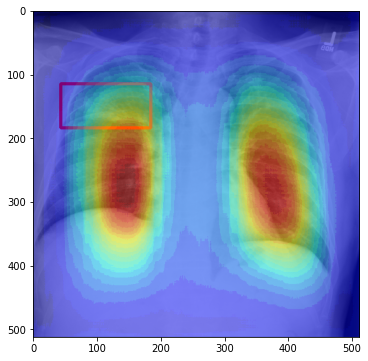

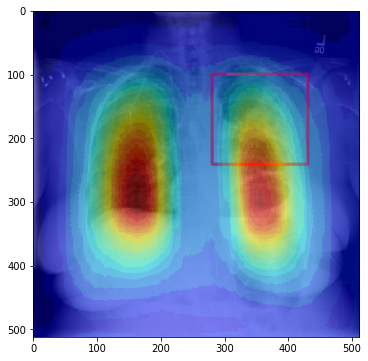

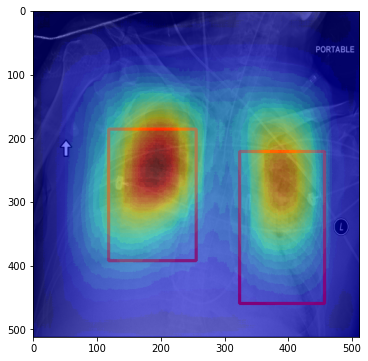

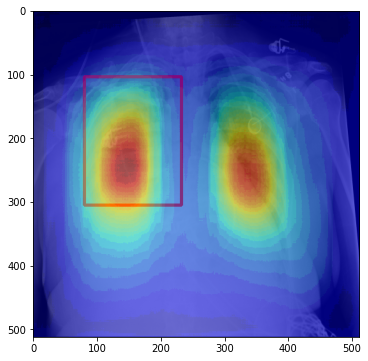

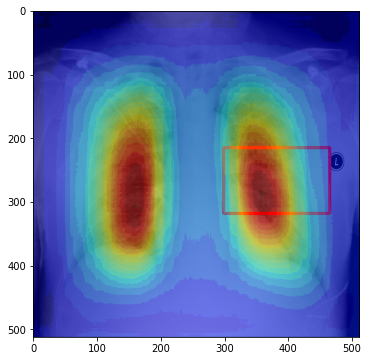

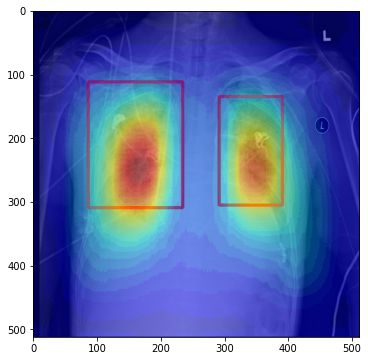

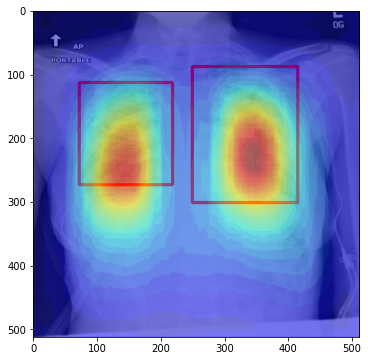

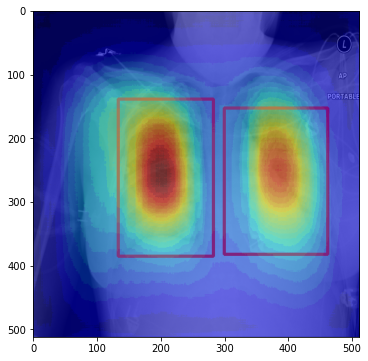

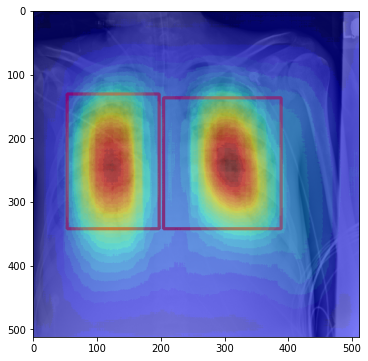

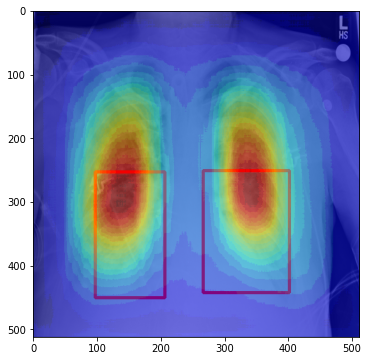

In [16]:
### 히트맵
trainable = False
resnet50_backbone = get_backbone(trainable_flag = trainable)
model_2 = RetinaNet(trainable_flag = trainable, backbone = resnet50_backbone)
model_2.load_weights("retinanet/trained_weights/Freezed")

input_image = tf.keras.Input(shape=(WIDTH, HEIGHT, 3), name="image")
predictions = model_2(input_image, training=True)

detections = DecodePredictions()(predictions)
inference_model = tf.keras.Model(inputs=input_image, outputs=detections)

for i, test in enumerate(test_dataset):
    img, label = test
    img_1 = tf.cast(img, dtype = tf.float32)/255.
    detections = inference_model.predict(img_1)
    #print(detections)
    img = img[0].numpy()
    Visualize_Heattmap_on_Image(img, detections, label)
    
    plt.show()
    if i == 50:
        break

## 6.2. Heatmap (with NMS) ver.1

class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=NUM_CLASSES,
        confidence_threshold=0.0,
        nms_iou_threshold=0.5,
        max_detections_per_class=50,
        max_detections=50,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = NUM_CLASSES
        self.confidence_threshold = confidence_threshold # 탐지가 제거되는 최소 클래스 확률
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )
    # [[[x_center. y_center. w. h. class_1_score. class_2_score], ....]]]
    # (1, 12276, 5)
    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        # 중심 좌표에서 코너 좌표로 변환
        boxes_transformed = xywh_to_corners(boxes)
        return boxes_transformed

    def call(self, predictions, width = WIDTH, height = HEIGHT):
        anchor_boxes = self._anchor_box.get_anchors(width, height)
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )
    
def Visualize_Heattmap_on_Image(image, result, label, width = WIDTH, height = HEIGHT):
    # NMS 결과 데이터
    num_detections = result.valid_detections[0]
    boxes = result.nmsed_boxes[0][:num_detections]
    scores = result.nmsed_scores[0][:num_detections] * 100
    scores = scores.astype(int)
    
    # 히트맵
    heatmap = np.zeros((height, width), dtype = "float32")
    
    # 모든 스코어 합
    for box, score in zip(boxes, scores):
        box = box.astype(int)
        xmin, ymin, xmax, ymax = box
        heatmap[ymin:ymax, xmin:xmax] += score
    
    # 정규화
    #heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # 1D -> 3D
    heatmap = np.uint8(heatmap * 255)
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 원래 label boxing하기
    # GT label
    for i in range(len(label)):
        x1, y1, w, h = label[i][0], label[i][1], label[i][2], label[i][3]
        image = cv2.rectangle(image, (x1, y1), (x1+w, y1 + h), (255,0,0), 3)
    plt.figure(figsize=(7, 7))
    plt.imshow(image, cmap=plt.cm.bone)
    
    # overlap하기
    plt.imshow(heatmap, "jet", alpha = 0.5)
    plt.show()
    #return heattmap_image

trainable = False
resnet50_backbone = get_backbone(trainable_flag = trainable)
model_2 = RetinaNet(trainable_flag = trainable, backbone = resnet50_backbone)
model_2.load_weights("retinanet/trained_weights/Fine-tuned")

input_image = tf.keras.Input(shape=(WIDTH, HEIGHT, 3), name="image")
predictions = model_2(input_image, training=True)

detections = DecodePredictions(confidence_threshold=0.0)(predictions)
inference_model = tf.keras.Model(inputs=input_image, outputs=detections)

for i, test in enumerate(test_dataset):
    img, label = test
    img_1 = tf.cast(img, dtype = tf.float32)/255.
    detections = inference_model.predict(img_1)
    #print(detections)
    img = img[0].numpy()
    Visualize_Heattmap_on_Image(img, detections, label)
    
    plt.show()
    if i == 5:
        break
